# experiment 2

In [26]:
!pip install kaggle wandb onnx -Uq
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [28]:
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json

In [29]:
! chmod 600 ~/.kaggle/kaggle.json

In [30]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

challenges-in-representation-learning-facial-expression-recognition-challenge.zip: Skipping, found more recently modified local copy (use --force to force download)


In [31]:
! unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip

Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
replace example_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: example_submission.csv  
replace fer2013.tar.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: fer2013.tar.gz          
replace icml_face_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: icml_face_data.csv      y
y

replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: test.csv                
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: train.csv               yy
y



In [32]:
!pip install wandb onnx -Uq

# data

In [33]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.auto import tqdm

import wandb

In [34]:
torch.backends.cudnn.deterministic = True
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Device configuration
device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)

Device available:  cuda


In [35]:
wandb.login()

True

# training

In [36]:
sweep_config = {
    'method': 'random',
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
    'parameters': {
        'learning_rate': {'values': [0.01, 0.005, 0.001, 0.0005]},
        'batch_size': {'values': [32, 64, 128]},
        'dropout_rate': {'values': [0.2, 0.3, 0.4]},
        'weight_decay': {'values': [1e-4, 1e-5, 1e-6]},
        'hidden_dim': {'values': [64, 128, 256]},
    }
}

In [37]:
sweep_id = wandb.sweep(sweep_config, project="Facial_Expression_Recognition_3")

Create sweep with ID: de1ahhg8
Sweep URL: https://wandb.ai/konstantine25b-free-university-of-tbilisi-/Facial_Expression_Recognition_3/sweeps/de1ahhg8


In [38]:
original_train_df = pd.read_csv('train.csv')

# First split: Create a test set (10% of original data)
train_val_df, test_df = train_test_split(original_train_df, test_size=0.1,
                                         random_state=42, stratify=original_train_df['emotion'])

# Second split: Split remaining data into training (80%) and validation (20%)
train_df, val_df = train_test_split(train_val_df, test_size=0.2,
                                    random_state=42, stratify=train_val_df['emotion'])

# Define emotion labels
emotion_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy',
                  4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [39]:
print(f"Original data size: {len(original_train_df)}")
print(f"Training set size: {len(train_df)} ({len(train_df)/len(original_train_df)*100:.1f}%)")
print(f"Validation set size: {len(val_df)} ({len(val_df)/len(original_train_df)*100:.1f}%)")
print(f"Test set size: {len(test_df)} ({len(test_df)/len(original_train_df)*100:.1f}%)")

# Print class distribution in each set
print("\nEmotion distribution:")
for i, emotion in emotion_labels.items():
    train_count = sum(train_df['emotion'] == i)
    val_count = sum(val_df['emotion'] == i)
    test_count = sum(test_df['emotion'] == i)
    print(f"  {emotion}: Train={train_count}, Val={val_count}, Test={test_count}")


Original data size: 28709
Training set size: 20670 (72.0%)
Validation set size: 5168 (18.0%)
Test set size: 2871 (10.0%)

Emotion distribution:
  Angry: Train=2877, Val=719, Test=399
  Disgust: Train=314, Val=78, Test=44
  Fear: Train=2950, Val=737, Test=410
  Happy: Train=5194, Val=1299, Test=722
  Sad: Train=3477, Val=870, Test=483
  Surprise: Train=2283, Val=571, Test=317
  Neutral: Train=3575, Val=894, Test=496


In [40]:
class FER2013Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        pixels = [int(pixel) for pixel in row['pixels'].split()]
        image = np.array(pixels, dtype=np.uint8).reshape(48, 48)

        # Convert to PIL Image for transforms
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        label = row['emotion']
        return image, label

In [41]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Validation and test sets only need basic transformations
val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [42]:
train_dataset = FER2013Dataset(train_df, transform=train_transform)
val_dataset = FER2013Dataset(val_df, transform=val_test_transform)
test_dataset = FER2013Dataset(test_df, transform=val_test_transform)

# Create a small subset for overfitting test (20 samples)
indices = list(range(20))
overfit_dataset = torch.utils.data.Subset(train_dataset, indices)

In [43]:
class ImprovedCNN(nn.Module):
    def __init__(self, dropout_rate=0.3, hidden_dim=128):
        super(ImprovedCNN, self).__init__()


        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(128 * 6 * 6, hidden_dim)
        self.bn4 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, 7)

    def forward(self, x):

        x = self.pool1(F.relu(self.bn1(self.conv1(x))))

        x = self.pool2(F.relu(self.bn2(self.conv2(x))))

        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        x = x.view(-1, 128 * 6 * 6)
        x = F.relu(self.bn4(self.fc1(x)))
        x = self.dropout1(x)
        x = self.fc2(x)

        return x


In [44]:
def create_dataloaders(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    overfit_loader = DataLoader(overfit_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    return train_loader, val_loader, test_loader, overfit_loader


In [45]:
def compute_accuracy(loader, model, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    return accuracy, all_preds, all_labels


# test for 20 data overfit

In [48]:
indices = list(range(20))
overfit_dataset = torch.utils.data.Subset(train_dataset, indices)
overfit_loader = DataLoader(overfit_dataset, batch_size=16, shuffle=True, pin_memory=True)


In [46]:
def test_overfitting():
    print("Running overfitting test to check model architecture...")

    # Initialize model for overfitting test
    model = ImprovedCNN(dropout_rate=0.3, hidden_dim=128).to(device)

    # Define loss function and optimizer for overfitting test
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    # Initialize wandb run for overfitting test
    with wandb.init(project="Facial_Expression_Recognition_3", name="overfitting_test"):
        overfit_losses = []
        overfit_accs = []

        epochs = 30
        for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            for images, labels in overfit_loader:
                images = images.to(device)
                labels = labels.to(device)

                # Forward pass
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            overfit_loss = running_loss / len(overfit_loader)
            overfit_acc = 100 * correct / total
            overfit_losses.append(overfit_loss)
            overfit_accs.append(overfit_acc)

            # Log to wandb
            wandb.log({
                "overfit_epoch": epoch + 1,
                "overfit_loss": overfit_loss,
                "overfit_accuracy": overfit_acc
            })

            print(f"Overfit Epoch {epoch+1}/{epochs}, Loss: {overfit_loss:.4f}, Acc: {overfit_acc:.2f}%")

        # Plot the overfitting test results
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(overfit_losses)
        plt.title('Overfitting Test - Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        plt.subplot(1, 2, 2)
        plt.plot(overfit_accs)
        plt.title('Overfitting Test - Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')

        plt.tight_layout()
        plt.savefig('overfit_test.png')
        plt.show()

        wandb.log({"overfit_test_plot": wandb.Image('overfit_test.png')})

        # Check if model can overfit
        if max(overfit_accs) > 95:
            print("Model passed the overfitting test! Proceeding with full training.")
            return True
        else:
            print("Warning: Model may have issues with gradient flow as it didn't achieve high accuracy on the small dataset.")
            return False


Running overfitting test to check model architecture...


Overfit Epoch 1/30, Loss: 2.4100, Acc: 15.00%
Overfit Epoch 2/30, Loss: 1.3525, Acc: 40.00%
Overfit Epoch 3/30, Loss: 1.4272, Acc: 60.00%
Overfit Epoch 4/30, Loss: 1.0353, Acc: 85.00%
Overfit Epoch 5/30, Loss: 1.1916, Acc: 80.00%
Overfit Epoch 6/30, Loss: 0.9157, Acc: 85.00%
Overfit Epoch 7/30, Loss: 1.0702, Acc: 80.00%
Overfit Epoch 8/30, Loss: 0.9121, Acc: 80.00%
Overfit Epoch 9/30, Loss: 0.7126, Acc: 90.00%
Overfit Epoch 10/30, Loss: 0.6071, Acc: 90.00%
Overfit Epoch 11/30, Loss: 0.7348, Acc: 90.00%
Overfit Epoch 12/30, Loss: 0.6527, Acc: 90.00%
Overfit Epoch 13/30, Loss: 0.4649, Acc: 100.00%
Overfit Epoch 14/30, Loss: 0.8879, Acc: 85.00%
Overfit Epoch 15/30, Loss: 0.5619, Acc: 95.00%
Overfit Epoch 16/30, Loss: 0.7871, Acc: 90.00%
Overfit Epoch 17/30, Loss: 0.3112, Acc: 100.00%
Overfit Epoch 18/30, Loss: 0.5016, Acc: 100.00%
Overfit Epoch 19/30, Loss: 0.3922, Acc: 90.00%
Overfit Epoch 20/30, Loss: 0.3409, Acc: 100.00%
Overfit Epoch 21/30, Loss: 0.4077, Acc: 100.00%
Overfit Epoch 22/

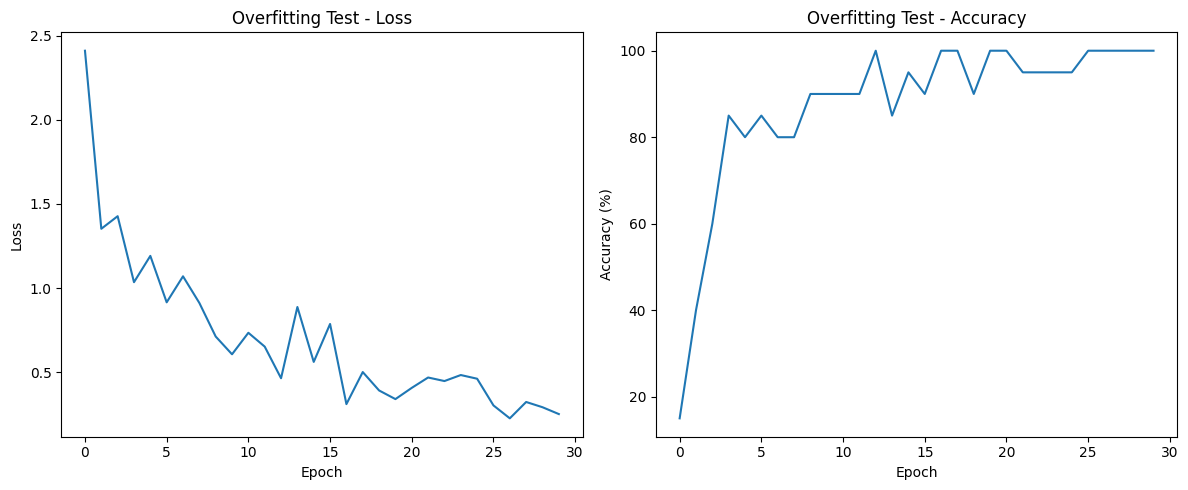

Model passed the overfitting test! Proceeding with full training.


overfit_accuracy,▁▃▅▇▆▇▆▆▇▇▇▇█▇█▇██▇███████████
overfit_epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
overfit_loss,█▅▅▄▄▃▄▃▃▂▃▂▂▃▂▃▁▂▂▁▂▂▂▂▂▁▁▁▁▁
overfit_accuracy,100
overfit_epoch,30
overfit_loss,0.25207


In [49]:
passed_overfit_test = test_overfitting()

# Training model

In [64]:
def compute_loss(loader, model, criterion, device):
    """Compute the loss on a dataset without updating model parameters"""
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(loader)

def visualize_predictions(loader, model, emotion_labels, device, num_samples=8):
    """Visualize model predictions on a few samples"""
    model.eval()
    all_images = []
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # Convert to CPU for visualization
            all_images.extend(images.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_preds.extend(preds.cpu().numpy())

            if len(all_images) >= num_samples:
                break

    # Select a subset of images to display
    indices = np.random.choice(len(all_images), min(num_samples, len(all_images)), replace=False)

    # Create a grid of images with their true and predicted labels
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.flatten()

    for i, idx in enumerate(indices):
        if i < len(axes):
            img = all_images[idx].squeeze()  # Remove channel dimension for grayscale
            img = (img * 0.5) + 0.5  # Denormalize

            true_label = emotion_labels[all_labels[idx]]
            pred_label = emotion_labels[all_preds[idx]]

            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f"True: {true_label}\nPred: {pred_label}")
            axes[i].axis('off')

    plt.tight_layout()
    plt.savefig('prediction_samples.png')
    wandb.log({"prediction_samples": wandb.Image('prediction_samples.png')})


In [65]:
def train_model(config=None):
    with wandb.init(project="Facial_Expression_Recognition_3", config=config):
        # Access all hyperparameter values from wandb.config
        config = wandb.config

        # Create model and dataloaders with the current config
        model = ImprovedCNN(dropout_rate=config.dropout_rate, hidden_dim=config.hidden_dim).to(device)
        train_loader, val_loader, test_loader, _ = create_dataloaders(config.batch_size)

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

        # Learning rate scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.5, verbose=True)

        # Initialize best validation accuracy
        best_val_acc = 0
        best_model_path = f"best_model_{wandb.run.id}.pt"

        # Training loop
        num_epochs = 30
        for epoch in range(num_epochs):
            # Training phase
            model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0

            for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
                images = images.to(device)
                labels = labels.to(device)

                # Forward pass
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()

                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()
                train_loss += loss.item()

            train_loss /= len(train_loader)
            train_acc = 100 * train_correct / train_total

            # Validation phase
            val_acc, val_preds, val_labels = compute_accuracy(val_loader, model, device)
            val_loss = compute_loss(val_loader, model, criterion, device)

            # Log metrics to wandb
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": train_loss,
                "train_accuracy": train_acc,
                "val_loss": val_loss,
                "val_accuracy": val_acc,
                "learning_rate": optimizer.param_groups[0]['lr']
            })

            # Print progress
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

            # Update learning rate scheduler
            scheduler.step(val_acc)

            # Save the best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), best_model_path)
                print(f"Model improved! Saved checkpoint (Val Acc: {val_acc:.2f}%)")

                # Log confusion matrix for best model
                cm = confusion_matrix(val_labels, val_preds)
                plt.figure(figsize=(10, 8))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                            xticklabels=list(emotion_labels.values()),
                            yticklabels=list(emotion_labels.values()))
                plt.xlabel('Predicted')
                plt.ylabel('True')
                plt.title(f'Confusion Matrix (Validation) - Epoch {epoch+1}')
                plt.tight_layout()
                plt.savefig(f'confusion_matrix_epoch_{epoch+1}.png')
                wandb.log({"confusion_matrix": wandb.Image(f'confusion_matrix_epoch_{epoch+1}.png')})

        # Load the best model for final evaluation
        model.load_state_dict(torch.load(best_model_path))

        # Test the model
        test_accuracy, test_preds, test_labels = compute_accuracy(test_loader, model, device)

        # Compute per-class metrics
        report = classification_report(test_labels, test_preds,
                                       target_names=list(emotion_labels.values()),
                                       output_dict=True)

        # Log test results
        wandb.log({
            "test_accuracy": test_accuracy,
            "test_f1_macro": report['macro avg']['f1-score'],
            "test_precision_macro": report['macro avg']['precision'],
            "test_recall_macro": report['macro avg']['recall']
        })

        # Log per-class metrics
        for emotion_idx, emotion_name in emotion_labels.items():
            if emotion_name in report:
                wandb.log({
                    f"test_{emotion_name}_f1": report[emotion_name]['f1-score'],
                    f"test_{emotion_name}_precision": report[emotion_name]['precision'],
                    f"test_{emotion_name}_recall": report[emotion_name]['recall']
                })

        # Create and log confusion matrix for test set
        cm = confusion_matrix(test_labels, test_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=list(emotion_labels.values()),
                    yticklabels=list(emotion_labels.values()))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix (Test)')
        plt.tight_layout()
        plt.savefig('test_confusion_matrix.png')
        wandb.log({"test_confusion_matrix": wandb.Image('test_confusion_matrix.png')})

        # Visualize some predictions
        visualize_predictions(test_loader, model, emotion_labels, device)

        print(f"Final Test Accuracy: {test_accuracy:.2f}%")
        return model, test_accuracy


In [66]:
print("Running full model training...")
default_config = {
    'learning_rate': 0.001,
    'batch_size': 64,
    'dropout_rate': 0.3,
    'weight_decay': 1e-5,
    'hidden_dim': 128
}

Running full model training...


Epoch 1/30 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 1/30, Train Loss: 1.5809, Train Acc: 38.21%, Val Loss: 1.5300, Val Acc: 44.06%
Model improved! Saved checkpoint (Val Acc: 44.06%)


Epoch 2/30 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 2/30, Train Loss: 1.3717, Train Acc: 47.45%, Val Loss: 1.3393, Val Acc: 48.84%
Model improved! Saved checkpoint (Val Acc: 48.84%)


Epoch 3/30 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 3/30, Train Loss: 1.3034, Train Acc: 49.97%, Val Loss: 1.2976, Val Acc: 49.52%
Model improved! Saved checkpoint (Val Acc: 49.52%)


Epoch 4/30 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 4/30, Train Loss: 1.2754, Train Acc: 51.16%, Val Loss: 1.3185, Val Acc: 49.88%
Model improved! Saved checkpoint (Val Acc: 49.88%)


Epoch 5/30 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 5/30, Train Loss: 1.2513, Train Acc: 52.18%, Val Loss: 1.2588, Val Acc: 52.42%
Model improved! Saved checkpoint (Val Acc: 52.42%)


Epoch 6/30 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 6/30, Train Loss: 1.2371, Train Acc: 52.70%, Val Loss: 1.2576, Val Acc: 52.13%


Epoch 7/30 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 7/30, Train Loss: 1.2252, Train Acc: 53.59%, Val Loss: 1.2390, Val Acc: 53.54%
Model improved! Saved checkpoint (Val Acc: 53.54%)


Epoch 8/30 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 8/30, Train Loss: 1.2120, Train Acc: 53.82%, Val Loss: 1.2027, Val Acc: 54.70%
Model improved! Saved checkpoint (Val Acc: 54.70%)


Epoch 9/30 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 9/30, Train Loss: 1.2013, Train Acc: 54.29%, Val Loss: 1.1958, Val Acc: 55.32%
Model improved! Saved checkpoint (Val Acc: 55.32%)


Epoch 10/30 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 10/30, Train Loss: 1.1952, Train Acc: 54.48%, Val Loss: 1.2528, Val Acc: 52.07%


Epoch 11/30 [Train]:   0%|          | 0/323 [00:10<?, ?it/s]

Epoch 11/30, Train Loss: 1.1918, Train Acc: 54.85%, Val Loss: 1.2109, Val Acc: 54.62%


Epoch 12/30 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 12/30, Train Loss: 1.1884, Train Acc: 54.60%, Val Loss: 1.1682, Val Acc: 56.21%
Model improved! Saved checkpoint (Val Acc: 56.21%)


Epoch 13/30 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 13/30, Train Loss: 1.1760, Train Acc: 55.35%, Val Loss: 1.1831, Val Acc: 54.93%


Epoch 14/30 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 14/30, Train Loss: 1.1742, Train Acc: 55.24%, Val Loss: 1.2049, Val Acc: 53.83%


Epoch 15/30 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 15/30, Train Loss: 1.1709, Train Acc: 55.40%, Val Loss: 1.2319, Val Acc: 53.66%


Epoch 16/30 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 16/30, Train Loss: 1.1707, Train Acc: 55.85%, Val Loss: 1.1734, Val Acc: 55.88%


Epoch 17/30 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 17/30, Train Loss: 1.1020, Train Acc: 58.45%, Val Loss: 1.1027, Val Acc: 58.88%
Model improved! Saved checkpoint (Val Acc: 58.88%)


Epoch 18/30 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 18/30, Train Loss: 1.0773, Train Acc: 59.15%, Val Loss: 1.1196, Val Acc: 58.13%


Epoch 19/30 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 19/30, Train Loss: 1.0634, Train Acc: 59.66%, Val Loss: 1.1371, Val Acc: 57.66%


Epoch 20/30 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 20/30, Train Loss: 1.0496, Train Acc: 60.04%, Val Loss: 1.1220, Val Acc: 57.95%


Epoch 21/30 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 21/30, Train Loss: 1.0501, Train Acc: 60.30%, Val Loss: 1.1130, Val Acc: 58.44%


Epoch 22/30 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 22/30, Train Loss: 0.9931, Train Acc: 62.84%, Val Loss: 1.0611, Val Acc: 60.20%
Model improved! Saved checkpoint (Val Acc: 60.20%)


Epoch 23/30 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 23/30, Train Loss: 0.9644, Train Acc: 63.77%, Val Loss: 1.0608, Val Acc: 60.86%
Model improved! Saved checkpoint (Val Acc: 60.86%)


Epoch 24/30 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 24/30, Train Loss: 0.9536, Train Acc: 64.08%, Val Loss: 1.0762, Val Acc: 59.98%


Epoch 25/30 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 25/30, Train Loss: 0.9343, Train Acc: 64.80%, Val Loss: 1.0759, Val Acc: 60.14%


Epoch 26/30 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 26/30, Train Loss: 0.9253, Train Acc: 65.14%, Val Loss: 1.0913, Val Acc: 59.27%


Epoch 27/30 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 27/30, Train Loss: 0.9224, Train Acc: 65.14%, Val Loss: 1.0834, Val Acc: 59.73%


Epoch 28/30 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 28/30, Train Loss: 0.8668, Train Acc: 67.33%, Val Loss: 1.0783, Val Acc: 60.14%


Epoch 29/30 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 29/30, Train Loss: 0.8481, Train Acc: 68.48%, Val Loss: 1.0876, Val Acc: 60.47%


Epoch 30/30 [Train]:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 30/30, Train Loss: 0.8382, Train Acc: 68.72%, Val Loss: 1.0855, Val Acc: 60.49%
Final Test Accuracy: 60.64%


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
learning_rate,████████████████▄▄▄▄▄▂▂▂▂▂▂▁▁▁
test_Angry_f1,▁
test_Angry_precision,▁
test_Angry_recall,▁
test_Disgust_f1,▁
test_Disgust_precision,▁
test_Disgust_recall,▁
test_Fear_f1,▁
test_Fear_precision,▁
test_Fear_recall,▁


Training completed with test accuracy: 60.64%


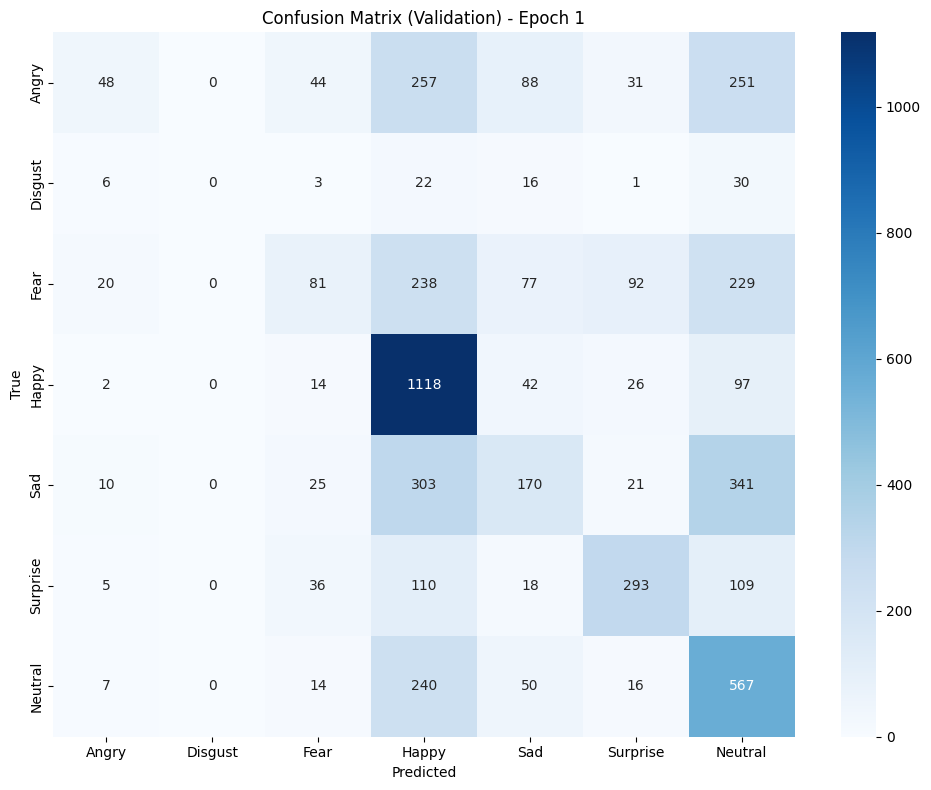

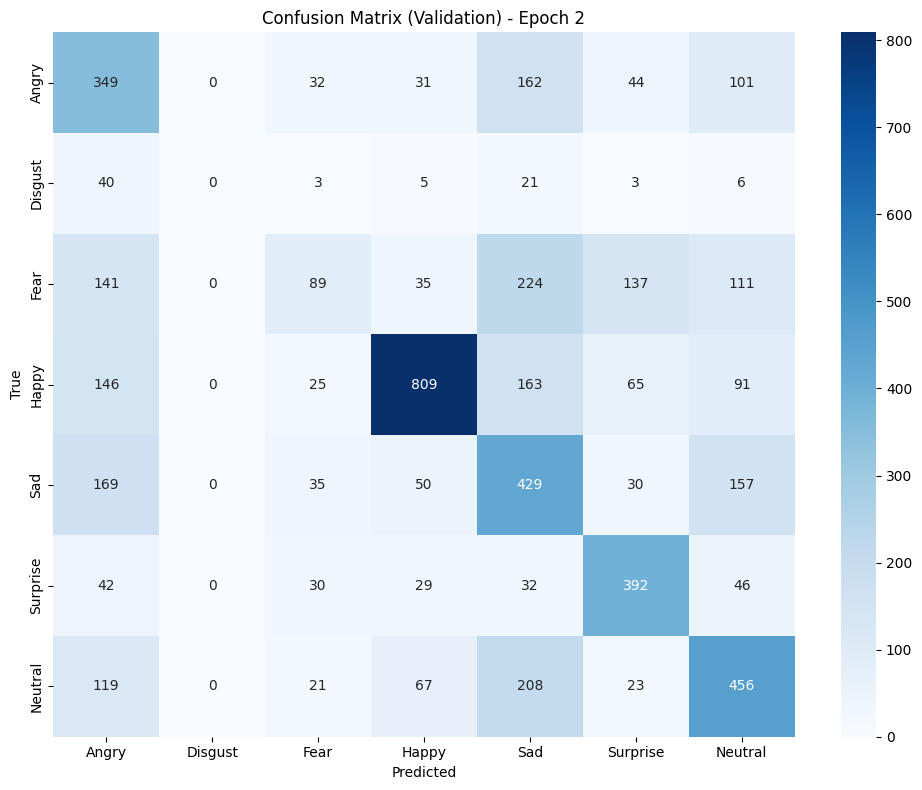

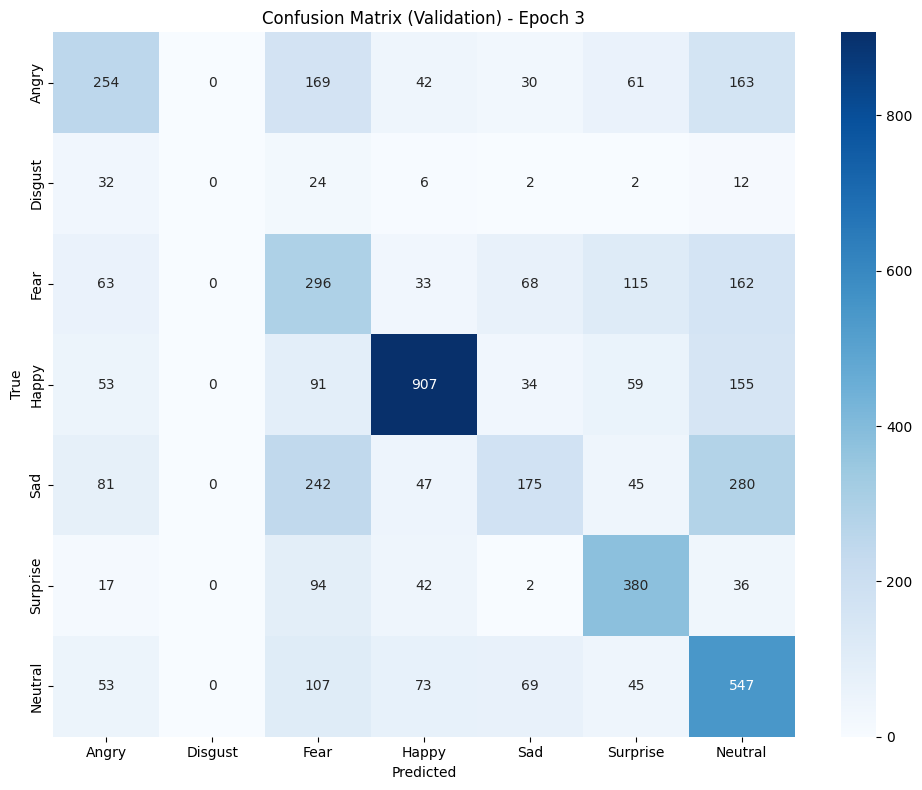

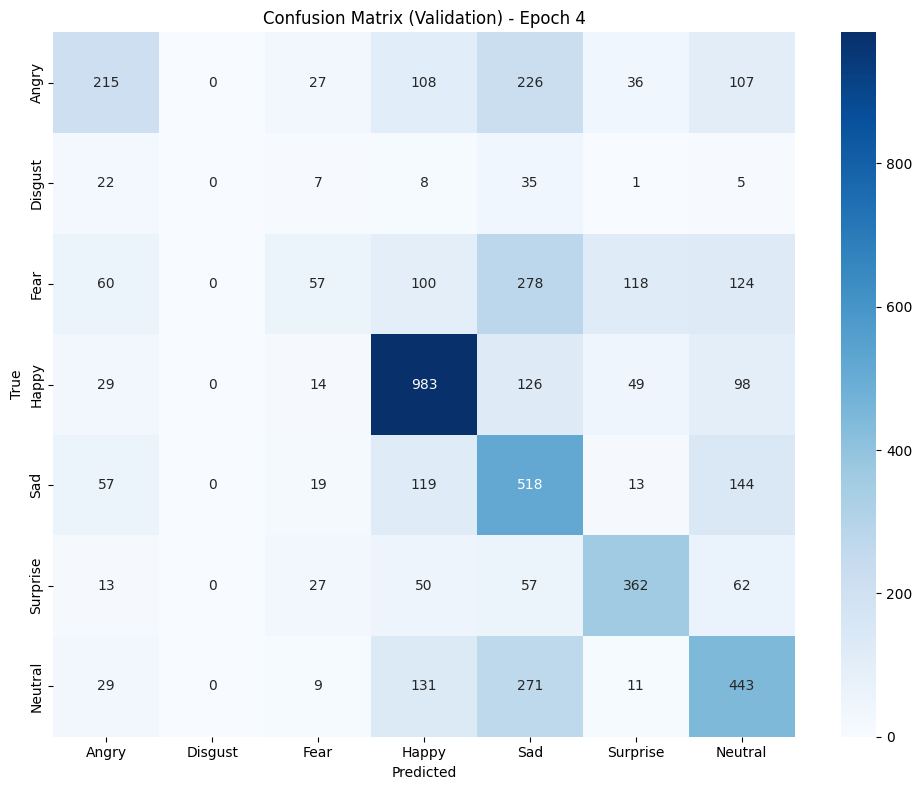

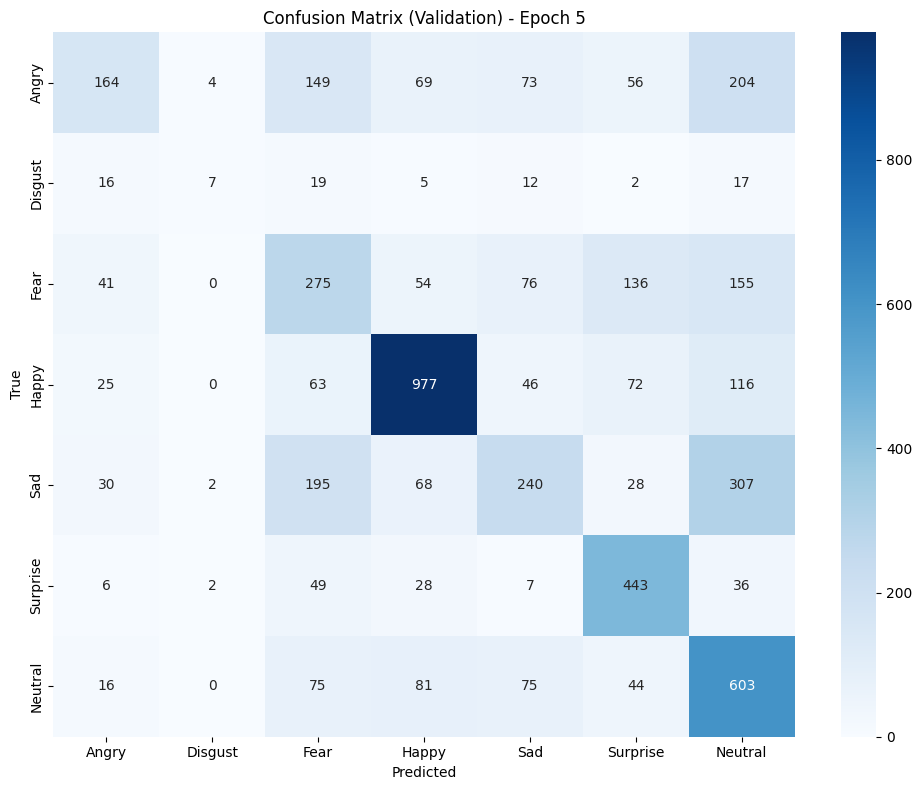

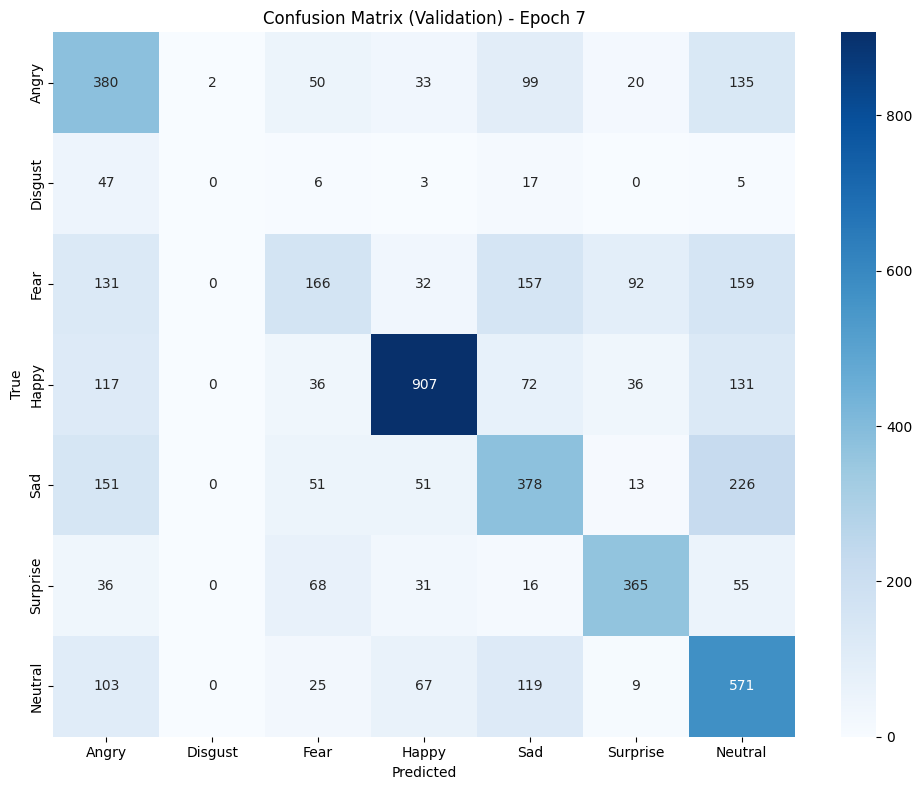

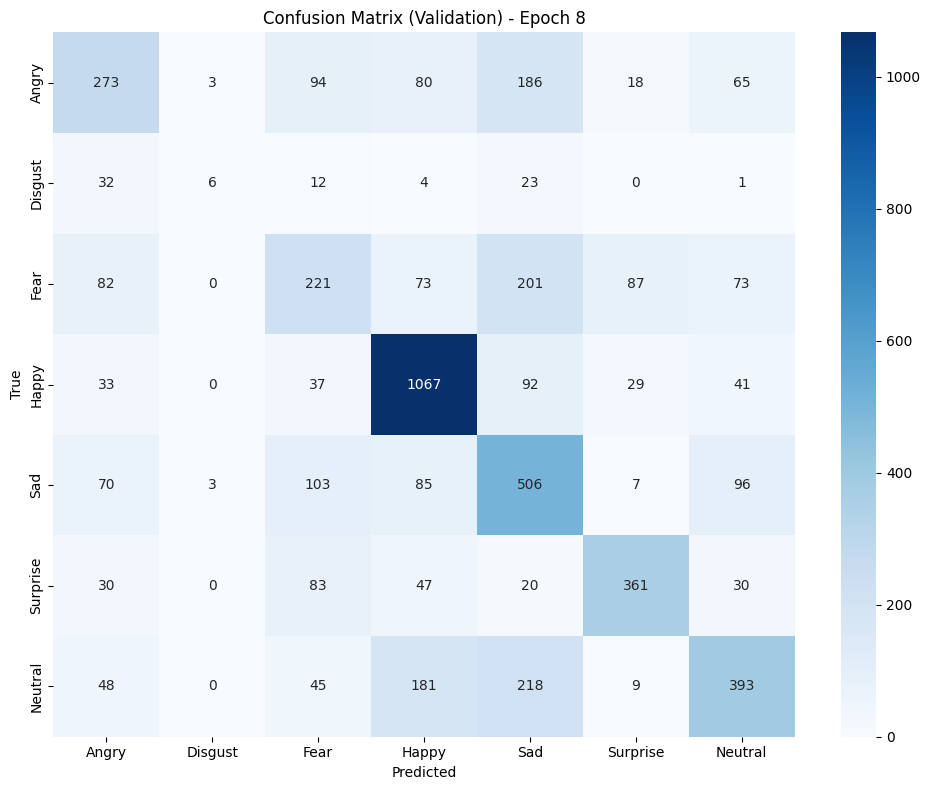

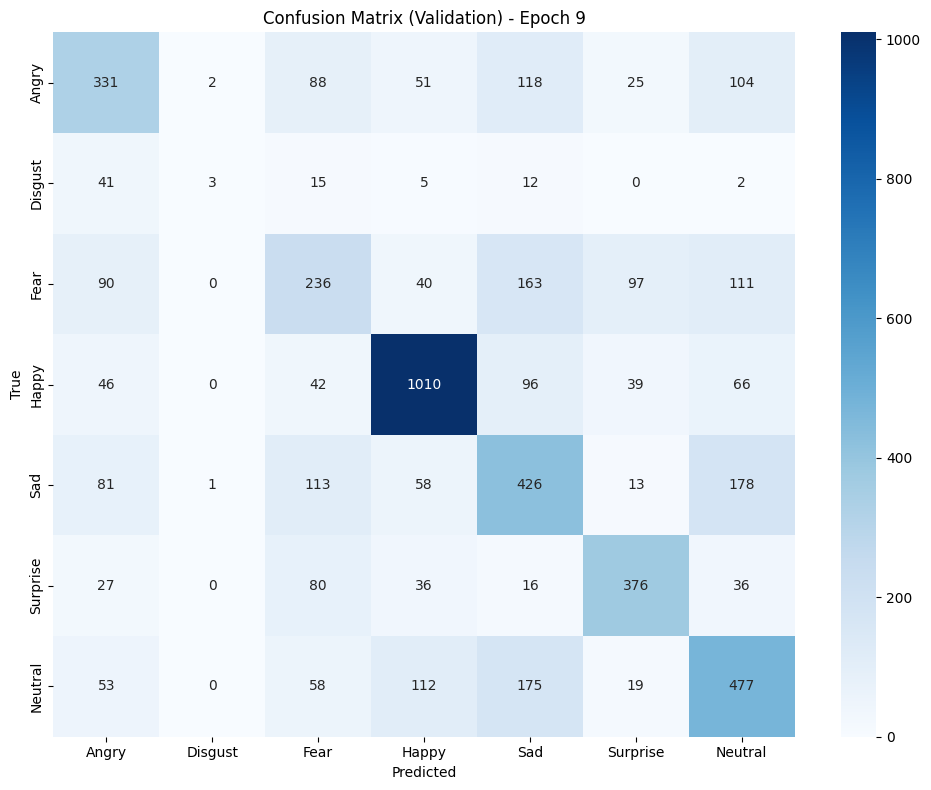

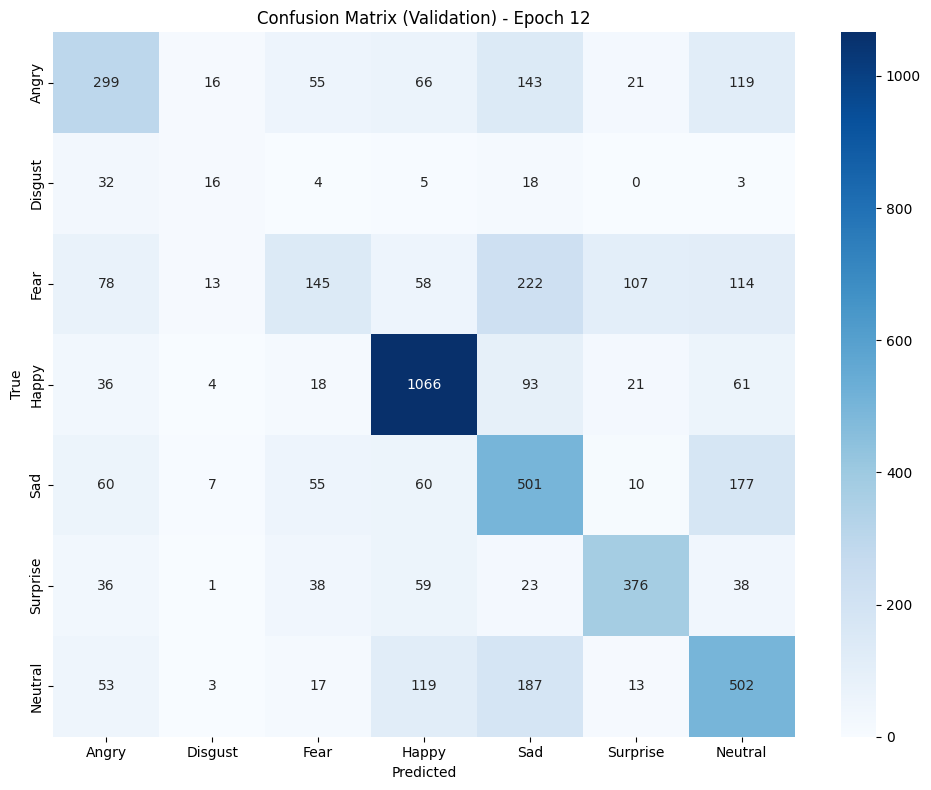

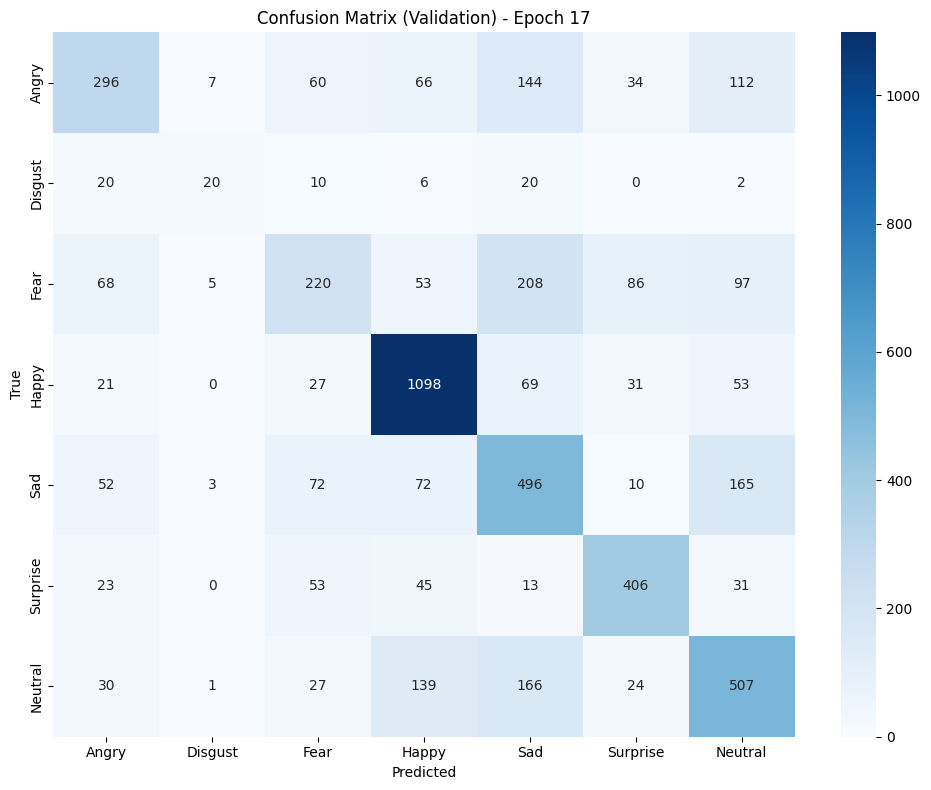

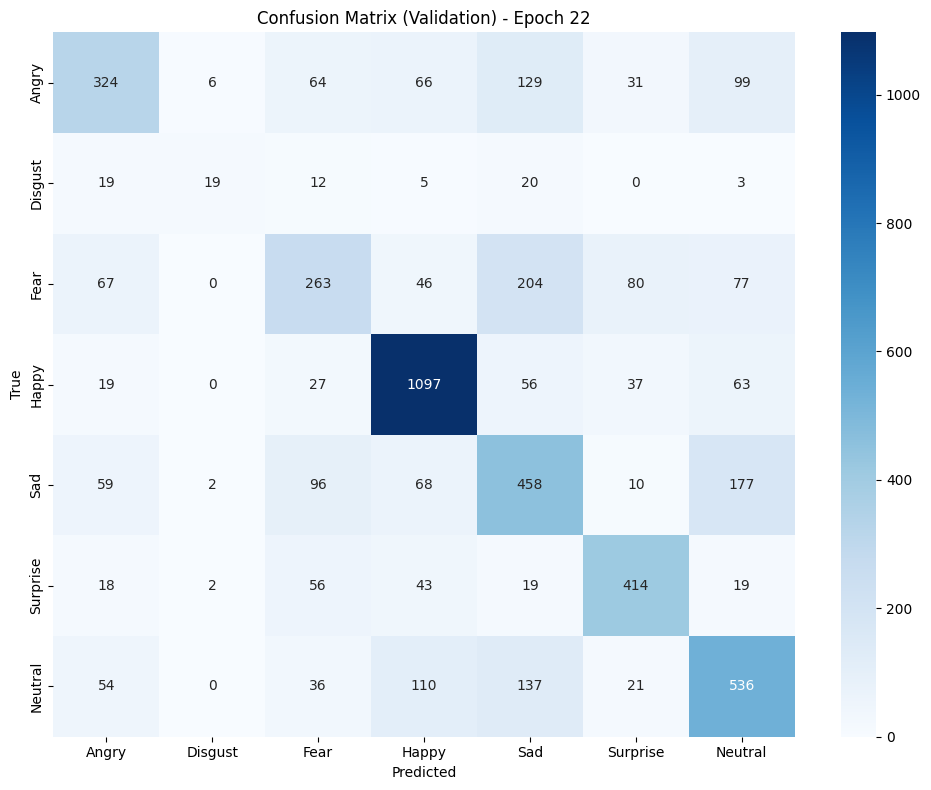

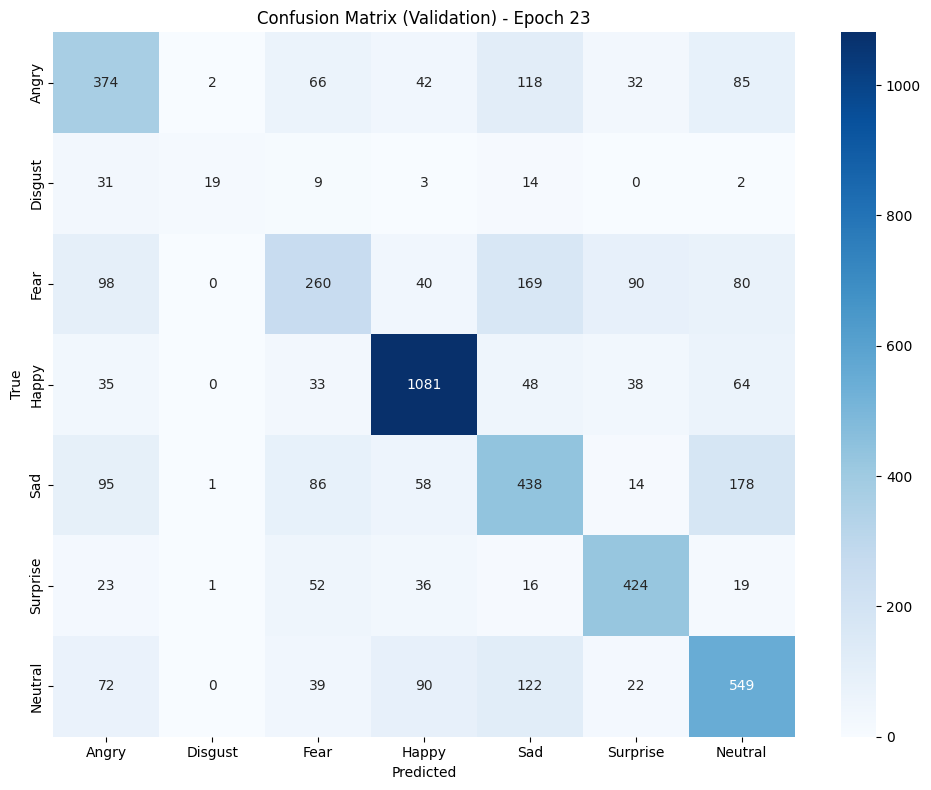

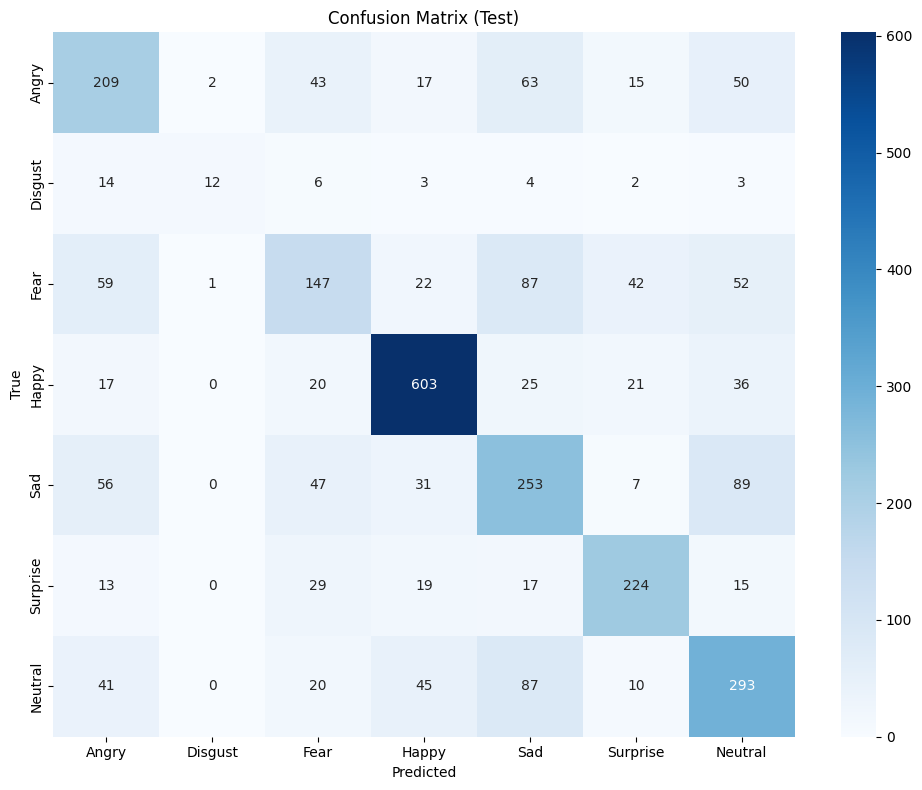

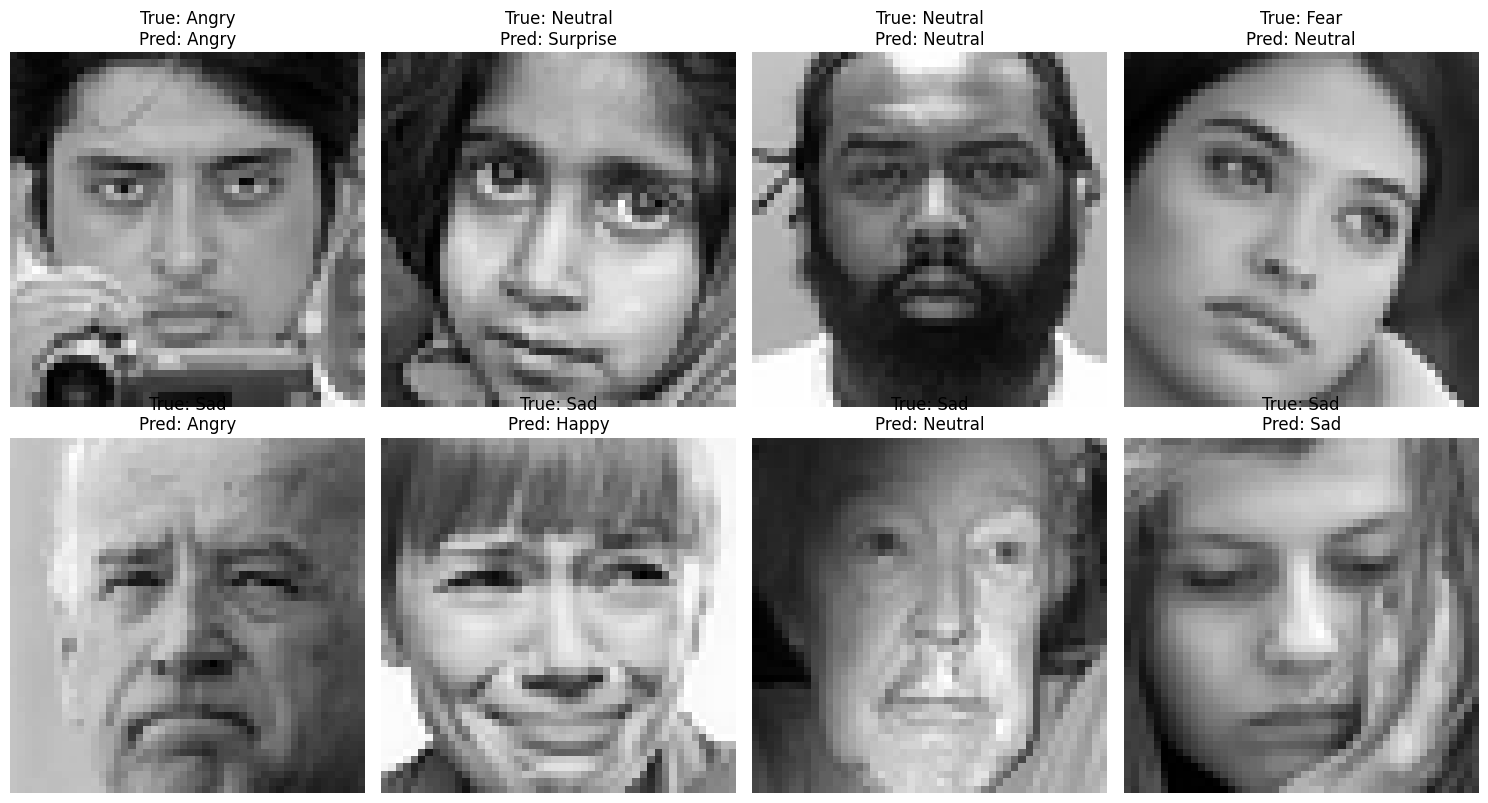

In [67]:
model, test_accuracy = train_model(default_config)
print(f"Training completed with test accuracy: {test_accuracy:.2f}%")


In [ ]:
print("\nRunning hyperparameter sweep to find the best model...")
wandb.agent(sweep_id, train_model, count=2)


In [ ]:
api = wandb.Api()
sweep = api.sweep(f"konstantine25b-free-university-of-tbilisi-/Facial_Expression_Recognition_3/sweeps/{sweep_id}")
runs = sorted(sweep.runs, key=lambda run: run.summary.get("val_accuracy", 0), reverse=True)
if runs:
    best_run = runs[0]
    print(f"\nBest run found: {best_run.name}")
    print(f"Best validation accuracy: {best_run.summary.get('val_accuracy', 0):.2f}%")
    print(f"Hyperparameters: {best_run.config}")

    # Load the best model for evaluation
    best_model_path = f"best_model_{best_run.id}.pt"

    try:
        # Create model with the best hyperparameters
        best_model = ImprovedCNN(
            dropout_rate=best_run.config.get('dropout_rate', 0.3),
            hidden_dim=best_run.config.get('hidden_dim', 128)
        ).to(device)

        # Load the model weights
        best_model.load_state_dict(torch.load(best_model_path))

        # Create dataloaders with the best batch size
        _, _, test_loader, _ = create_dataloaders(best_run.config.get('batch_size', 64))

        # Test the model
        test_accuracy, test_preds, test_labels = compute_accuracy(test_loader, best_model, device)

        # Compute per-class metrics
        report = classification_report(test_labels, test_preds,
                                      target_names=list(emotion_labels.values()),
                                      output_dict=True)

        print(f"\nFinal Test Accuracy with best model: {test_accuracy:.2f}%")
        print("\nClassification Report:")
        print(classification_report(test_labels, test_preds, target_names=list(emotion_labels.values())))

        # Create confusion matrix for test set
        cm = confusion_matrix(test_labels, test_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=list(emotion_labels.values()),
                    yticklabels=list(emotion_labels.values()))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix (Test) - Best Model')
        plt.tight_layout()
        plt.savefig('best_model_confusion_matrix.png')

        # Visualize some predictions with the best model
        visualize_predictions(test_loader, best_model, emotion_labels, device)

    except Exception as e:
        print(f"Error loading or evaluating best model: {e}")
        print("You may need to manually download the best model from W&B.")
else:
    print("No completed runs found in the sweep.")

In [ ]:
wandb.finish()